## Testing and Characterizing the Linker

We have several goals here:
 * Define a useful sample of fakes
 * Run linker
 * Identify triplets and work out ways of adding points efficiently
 * Compare detected objects to input fake catalog

As out initial sample, we'll use simulated detections of fake TNOs, all with a=40AU, in the Y1 X-fields.
We won't worry about simulating magnitudes or single-epoch detection efficiencies for now; initial goal is just geometric properties of the linker. Want to make sure we can efficiently detect objects with weird orbits (e.g. retrograde), and objects which graze or cross fields.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload
from __future__ import division
import numpy as np
import pandas as pd
from KBO import *
from linktools import *
from DESKBO import DEScands
import matplotlib.pyplot as plt

### Fake catalogs:

*Here is a running list of fake catalogs generated so far:*

Category | Field | Season | fake bodies | observations | generation parameters
--- | --- | --- | --- | --- | --- 
Sednoids | S1 | Y1 | `fakes_200_500_AU_S1.csv` | `fake_detections_200_500_AU_S1_Y1.csv` | $200<a<500$, $10<i<120$, $0<H<3$, peri>70, $0.55<e<0.95$
Classical/Scattered | S1 | Y1 | `fakes_40_50_AU_S1.csv` | `fake_detections_40_50_AU_S1_Y1.csv` | $40<a<50$, $10<i<120$, $4<H<8$, peri>30, $e<0.25$

#### Open the fake catalogs. The first is the truth, with fakeids and orbital elements.  The second is the Y1 detections.

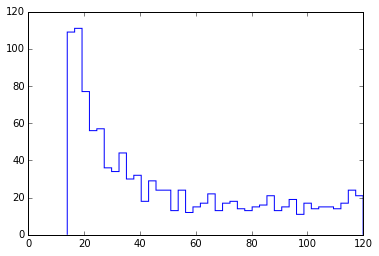

In [2]:
# Set up some global configuration parameters
target='S1'
truth_in = 'fakes_40_50_AU_S1.csv'
fakes_det_in = 'fake_detections_40_50_AU_S1_Y1.csv'
do_noise = True
noise_detections_per_exposure=100
astrometric_err = 0.2
fakes_truth = pd.read_csv(truth_in) 
fakes_det = pd.read_csv(fakes_det_in)
n, bins, patches = plt.hist(fakes_truth.i, bins=40, histtype='step', color='b')

In [29]:
# Create the input catalog

fake_cat = Catalog(rows=fakes_det_in,fakeid=int,date_obs=str,expnum=int,exptime=float, 
                   ra=float,dec=float,mag=float,band=str,ccdnum=int,nite=int,objid=int)
fake_cat.rename(date='date_obs', ccd='ccdnum')
fake_cat.refactor('date',toDateTime)
fake_cat.refactor('ra',  lambda ra: hours(ra))
fake_cat.refactor('dec', lambda dec: degrees(dec))

In [30]:
def gen_noise_catalog(cat_signal, fakes_per_exposure=100):
    '''
    Returns a noise catalog containing specificed number of fakes in each exposure in the input signal catalog.
    '''
    expnums = sorted(set([p.expnum for p in cat_signal]))   # exposure numbers in the input catalog
#    print 'expnums: ', expnums
    allexps = [e for e in exposures if e.expnum in expnums]  # obtain exposure info
#    print 'Creating list of exposures...'
    exps_noise = [DECamExposure(expnum=e.expnum, exptime=e.exptime, date=e.date, ra=e.ra, dec=e.dec, 
                                   nite=e.nite, obj=e.object, band=e.band) for e in allexps]
    print 'Making noise catalogs...'
    noise_catalogs = [genNoise(e, nfakes=fakes_per_exposure) for e in allexps]
#    flatten the noise catalogs for the individual exposures into one catalog
#    print 'Flattening noise catalogs...'
    big_noise_cat = Catalog([p for noise_catalog in noise_catalogs for p in noise_catalog])
    big_noise_cat.orderby('nite')
#    for p in big_noise_cat[:10]:
#        print ephem.date(p.date), hours(p.ra), degrees(p.dec), p.mag 
    return big_noise_cat

In [31]:
def merge_catalogs(cat1, cat2):
    '''
    Merges cat1 and cat2 into a single Catalog
    '''
    points = [p for p in cat1] + [p for p in cat2]
    return Catalog(points)
    

### Use KDTrees to speed up the search for linkable points

In [32]:
from scipy.spatial import KDTree

def make_kdtree(catalog):
    '''
    Makes a KDtree from the ra, dec points in catalog.
    '''
    x = np.array([[point.ra for point in catalog], 
                  [point.dec for point in catalog]]).transpose()
    return scipy.spatial.KDTree(x)

#### It would be interesting to convert the linker from using Catalog objects to pandas dataframes, which seem to have all the functionality (and more) of Catalogs, and are probably much faster. But for this initial test, and to establish a baseline, let's read the detected objects into a Catalog and use the original linker.

In [3]:
linkstuff = []    # some internals from the linker, for examination and debugging.

class ObjectLinker(object):
    def __init__(self, target, objcat, band = None, exclude_snobjids=None, date_start=None, look_ahead_visits=2):

# objcat is a Catalog (for now) which must contain at least the following columns:
#     date (as a DateTime object)
#     nite
#     ra, dec in radians or ephem.Angle objects
#     band
#     expnum
#     exptime (in seconds)
#     objid (a unique identifier, such as snobjid)
#     mag
#     ccd
        self.objects = objcat
        if band is not None: self.objects = Catalog(obj for obj in self.objects if obj.band == band)
        if exclude_snobjids is not None: self.objects = Catalog(obj for obj in self.objects if obj.objid not in exclude_snobjids)
#
        if date_start is not None: self.objects = Catalog(obj for obj in self.objects if obj.date>=date_start)
        self.objects.add_constant('obscode', 807)
        self.objects.add_constant('err', astrometric_err)
        self.objects.orderby('date')
        self.field = fields[target]
        self.band = band
        self.centerlat = Ecliptic(Equatorial(self.field.center)).lat
        self.look_ahead_visits = look_ahead_visits   # how many visits to look ahead for linking
        self.vmax = 150    # arcsec/day
        
    def sep(self, point1, point2):
        # returns separation between two points in arcsec
        return ephem.separation((point1.ra, point1.dec), (point2.ra, point2.dec))*180/np.pi*3600
        
    def link(self, objid):

        # get the object associated with this objid
        point = self.objects[objid]
        
        # link object and return
        next_objid = link_obj(point)
        return next_objid
    
    def cosine_cut(self, displacement):
        '''
        The requirement on directional alignment between two points and that expected from earth reflex motion.
        It's more generous for lower values of the displacement (in arcseconds).
        '''
        if displacement<400:
            return 0.7
        elif 400<displacement<=800:
            return 0.7 + (0.95-0.7)/(800-400)*(displacement-400)
        else:
            return 0.95
    
    def tno_like(self, point1, point2, lon1, lat1, dlon, dlat):
        '''
        returns True if point1 and point2 are in a TNO-like relationship to each other, i.e. displacement
        magnitude and direction consistent with earth reflex motion. 
        point1 = point in earlier visit
        point2 = point in subsequent visit that we are trying to link to point1.
        lon1, lat1 = ecliptic coords of point1
        dlon, dlat = expected change in direction from one visit to next: dlon = nextvisit.dlon - thisvisit.dlon, etc.
        '''
        lon2, lat2 = Ecliptic(Equatorial(point2.ra, point2.dec)).get()
        displacement = ephem.separation((lon2, lat2), (lon1, lat1))
        norm = np.sqrt(np.cos(self.centerlat)**2*dlon**2 + dlat**2)
        dot = np.cos(self.centerlat)**2*(lon2 - lon1)*dlon + (lat2 - lat1)*dlat
        if point2.date != point1.date:
            velocity = displacement/(point2.date - point1.date)
        else: 
            velocity=9999
        cosine = dot/(norm*displacement)
#        linkstuff.append(
#            dict([('cos',cosine),('objid1', point1.objid),('objid2', point2.objid),('velocity',velocity),
#                         ('dlon',dlon), ('dlat',dlat), ('displacement',displacement),
#                         ('norm',norm),('dot',dot),('objdlon',lon2-lon1),('objdlat',lat2-lat1)]
#                ))
        # The old way:
#        return True if cosine > np.cos(20*np.pi/180) and velocity < self.vmax*np.pi/(180*3600) else False 
#       The new way accounts for the noise in cosine for smaller values of displacement.
        displacement_asec = displacement*180/np.pi*3600
        return True if velocity<self.vmax and cosine>self.cosine_cut(displacement_asec) else False
            
        

       
    def link_obj(self, point):
        visits = self.field.visits
        visits.orderby('nite')
        thisvisit = visits[point.nite]
        if thisvisit is None:
            print 'This point\'s visit not found!'
            print point.date
            return []
        nextvisit = thisvisit
        next_obj = []
        for i in range(self.look_ahead_visits):
            
            # get the next visit
            try:
                nextvisit = next(visit for visit in visits if visit.nite > nextvisit.nite)
            except StopIteration: pass
            if nextvisit is None: 
                print "nextvisit is None!"
                return []
            
#            sep_max = self.vmax*np.pi/(180*3600)*(days between visits)
            current_objects = [obj for obj in self.objects if obj.nite == nextvisit.nite \
                               and (self.band is None or obj.band == self.band) ]
            #                  and ephem.separation((point.ra, point.dec), (obj.ra, obj.dec))<sep_max]
            # now the real work: for each object, test to see
            # if it's consistent with being the next point in
            # a KBO trajectory.
            lon, lat = Ecliptic(Equatorial(point.ra, point.dec)).get()
            dlon, dlat = nextvisit.dlon - thisvisit.dlon, nextvisit.dlat - thisvisit.dlat
            for point2 in current_objects:
                if self.tno_like(point, point2, lon, lat, dlon, dlat): next_obj.append(point2)
        return next_obj

In [4]:
fake_ids = sorted(set([p.fakeid for p in fake_cat]))


NameError: name 'fake_cat' is not defined

## Carry out the linking à la linkfit2.py

In [13]:
def do_link(linker):
    good_triplets = []
    cat1 = linker.objects
    for obj1 in cat1:
        print 'Linking point: ', obj1.date, obj1.ra, obj1.dec, obj1.fakeid, obj1.objid
        next_points = linker.link_obj(obj1)
        for obj2 in next_points:
#            print '.',
            next_next_points = linker.link_obj(obj2)
            for obj3 in next_next_points:
                triple=Catalog([obj1, obj2, obj3])
                ra = [obj1.ra, obj2.ra, obj3.ra]
                dec=[obj1.dec, obj2.dec, obj3.dec]
                dates = [exposure_midpoint(obj1, fields[target]), exposure_midpoint(obj2, fields[target]), 
                         exposure_midpoint(obj3, fields[target])]
#                print '-',
#                if obj1.fakeid>0 and obj2.fakeid>0 and obj3.fakeid==-1:
#                    for d in linkstuff:
#                        if d['objid1']==obj2.objid and d['objid2']==obj3.objid:
#                            print 'cosine, velocity, displacement: ', d['cos'], d['velocity']*180/np.pi*3600, d['displacement']*180/np.pi*3600
#                    for point in triple:
 #                       print ephem.date(point.date), hours(point.ra), degrees(point.dec), point.expnum, point.exptime, point.band, point.obscode, point.err, point.fakeid, point.objid 
                orbit = Orbit(triple)
                if orbit.chisq<2 and orbit.elements['a']>20:    # good triplet
                    good_triplets.append(triple)
                    print orbit.elements
                    for point in triple:
                        print point.date, point.ra, point.dec, point.fakeid, point.objid
                    print
    return good_triplets

### Now what to do with all these triplets? Let's try to grow triplets by adding points that occur in multiple triplets.

For the moment: assume we will find some efficient and elegant way of consolidating the triplets from a given object. In the mean time, just combine all the points from the triplets associated with a given object into one set of observations, and re-fit.

In [7]:
def merge_triplets(good_triplets):
    allobs = Catalog(set([obs for triplet in good_triplets for obs in triplet]))
    allobs.orderby('date')
    return allobs

#### Carry out linking fake TNO by fake TNO

In [46]:
orbits = []
truth = []
found_truth = []
not_found_truth = []
not_found_ids = []
first_nite_found = []
first_nite_not_found = []
# Make sure our fake catalog contains points from this field's nites only
# Also, choose r-band only for now. 
our_nites = [v.nite for v in fields[target].visits]
print 'our_nites = ', our_nites
fake_cat = Catalog([p for p in fake_cat if p.nite in our_nites and p.band=='r'])
# add random points to the catalog:
if do_noise:
    print 'Generating noise catalog...'
    noise_cat = gen_noise_catalog(fake_cat, fakes_per_exposure=noise_detections_per_exposure)
    print 'Finished generating noise catalog!'
# Now "link" each object at a time. This is a cheat since we know the truth.
for fakeid in fake_ids:
#for fakeid in [4090]:
    print 'Processing fakeid... ', fakeid
    if isDetectable(fake_cat, fakeid, target):
        df_true = fakes_truth.loc[fakes_truth['fakeid'] == fakeid]    # dataframe from truth catalog
        truth.append(df_true.iloc[0])    # pandas series representing this single row of the table
        this_fake_cat = Catalog([p for p in fake_cat if p.fakeid==fakeid])
        if do_noise:
            full_cat = merge_catalogs(this_fake_cat, noise_cat)
        else:
            full_cat = this_fake_cat
        full_cat.orderby('date')
        full_cat.refactor('ra', lambda ra: hours(ra))
        full_cat.refactor('dec', lambda dec: hours(dec))
        outfile = 'noise_catalogs_40_50AU/cat_noise_'+str(fakeid)+'.csv'
        full_cat.write(outfile,('date','ra','dec','expnum','exptime','band','ccd','mag','fakeid','objid','nite'))
#        for p in full_cat[:100]:
#            print p.date,',', p.ra, ',',p.dec, ',',p.expnum,',', p.exptime,',', p.band,',', p.ccd,',',p.objid
#        linker = ObjectLinker(target, full_cat, look_ahead_visits=2)
#        good_triplets = do_link(linker)
#        allobs = merge_triplets(good_triplets)
#        if len(allobs)>2: 
#            found_truth.append(df_true.iloc[0])
##            orbits.append(Orbit(allobs))
#            first_nite_found.append([p.date for p in this_fake_cat][0])
#        else:
#            not_found_ids.append(fakeid) 
#            not_found_truth.append(df_true.iloc[0])
#            first_nite_not_found.append([p.date for p in this_fake_cat][0])

our_nites =  [20130831, 20130901, 20130907, 20130911, 20130915, 20130923, 20130927, 20131001, 20131009, 20131013, 20131024, 20131028, 20131105, 20131109, 20131112, 20131119, 20131128, 20131202, 20131209, 20131218, 20131222, 20131226, 20140102, 20140111, 20140118, 20140125, 20140201, 20140208]
Generating noise catalog...
Making noise catalogs...
Finished generating noise catalog!
Processing fakeid...  4090
Processing fakeid...  5855
Processing fakeid...  9422
Processing fakeid...  10637
Processing fakeid...  36904
Processing fakeid...  37057
Processing fakeid...  55161
Processing fakeid...  55600
Processing fakeid...  55932
Processing fakeid...  56406
Processing fakeid...  72570
Processing fakeid...  83808
Processing fakeid...  85877
Processing fakeid...  91105
Processing fakeid...  110191
Processing fakeid...  131085
Processing fakeid...  149104
Processing fakeid...  149342
Processing fakeid...  150786
Processing fakeid...  157840
Processing fakeid...  159362
Processing fakeid...  1678

In [14]:
# A different approach... read the signal+noise catalog from a file and proceed to linking right away.
cat_in = Catalog('noise_catalogs_40_50AU/cat_noise_4090.csv', date=float, ra=float, dec=float, expnum=int, exptime=float, band=str,
                mag=float, fakeid=int, objid=int, nite=int)
cat_in.refactor('date', lambda date: ephem.date(date))
cat_in.refactor('ra', lambda ra: hours(ra))
cat_in.refactor('dec', lambda dec: degrees(dec))

In [15]:
linker = ObjectLinker(target, cat_in, look_ahead_visits=2)
good_triplets = do_link(linker)

Linking point:  2013/9/1 05:50:23 2:55:36.28 0:01:25.1 -1 None
Linking point:  2013/9/1 05:50:23 2:51:44.05 -0:25:42.8 -1 None
Linking point:  2013/9/1 05:50:23 2:52:56.52 -0:52:51.1 -1 None
Linking point:  2013/9/1 05:50:23 2:48:50.95 -0:00:39.9 -1 None
Linking point:  2013/9/1 05:50:23 2:49:51.14 0:36:50.8 -1 None
Linking point:  2013/9/1 05:50:23 2:50:21.03 -0:05:10.6 -1 None
Linking point:  2013/9/1 05:50:23 2:52:36.16 -0:17:12.9 -1 None
Linking point:  2013/9/1 05:50:23 2:48:19.97 0:27:58.5 -1 None
Linking point:  2013/9/1 05:50:23 2:49:07.76 -0:32:20.3 -1 None
Linking point:  2013/9/1 05:50:23 2:49:26.53 -0:32:46.3 -1 None
Linking point:  2013/9/1 05:50:23 2:54:41.08 0:02:15.6 -1 None
Linking point:  2013/9/1 05:50:23 2:49:56.18 -0:12:56.9 -1 None
Linking point:  2013/9/1 05:50:23 2:54:30.14 -0:27:22.0 -1 None
Linking point:  2013/9/1 05:50:23 2:50:34.89 -0:27:05.5 -1 None
Linking point:  2013/9/1 05:50:23 2:52:39.49 0:14:43.7 -1 None
Linking point:  2013/9/1 05:50:23 2:54:52.80 

6


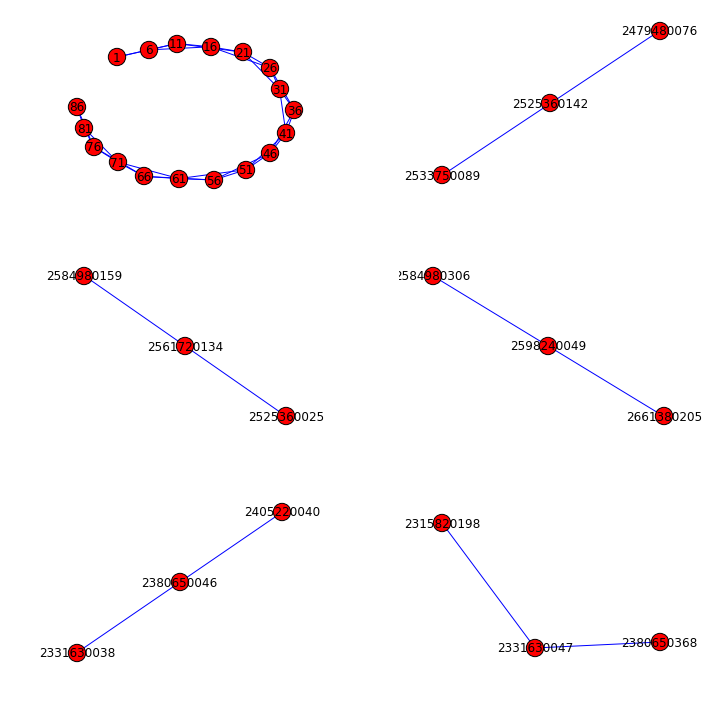

In [147]:
import networkx as nx

G = nx.Graph()
good_orbits = []
signal_triplets = [t for t in good_triplets if Orbit(t).ndof==1]
for triplet in signal_triplets:
    good_orbits.append(Orbit(triplet))
    observations = sorted([obs.objid for obs in triplet])
    G.add_nodes_from(observations)
    G.add_edge(observations[0], observations[1])
    G.add_edge(observations[1], observations[2])
subgraphs = [s for s in nx.connected_component_subgraphs(G)]
print len(subgraphs)
fig = plt.figure(1, edgecolor='k', facecolor='w', figsize=(12,12))
for i in range(6):
    ax=fig.add_subplot(3,2,i)
    nx.draw_spring(subgraphs[i],with_labels=True, ax=ax, node_size=300, label_size=12, edge_color='b')
plt.savefig('networkx_4090.pdf')
plt.savefig('networkx_4090.png')
    

[3, 18, 3, 3, 3, 3]


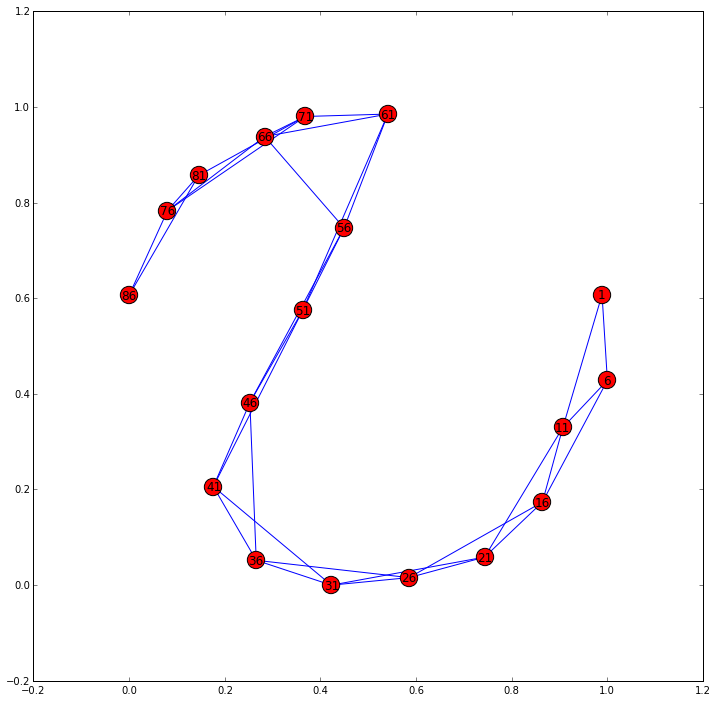

In [146]:
conn = nx.connected_components(G)
lengths = [len(c) for c in conn]
print lengths
subgraphs = nx.connected_component_subgraphs(G)
for g in subgraphs: 
    fig = plt.figure(1, edgecolor='k', facecolor='w', figsize=(12,12))
    ax=fig.add_subplot(1,1,1)
    if nx.number_of_nodes(g)>10:
        nx.draw_networkx(g, with_labels=True, ax=ax, node_size=300, edge_color='b')
    

In [82]:
def signal_triplet(triplet):
    return np.all([obs.fakeid>0 for obs in triplet])
def background_triplet(triplet):
    return np.all([obs.fakeid<0 for obs in triplet])
def mixed_triplet(triplet):
    return True if np.any([obs.fakeid>0 for obs in triplet]) and not np.all([obs.fakeid>0 for obs in triplet]) else False

In [101]:
orbits_s = [Orbit(t) for t in good_triplets if signal_triplet(t)]
orbits_b = [Orbit(t) for t in good_triplets if background_triplet(t)]
orbits_m = [Orbit(t) for t in good_triplets if mixed_triplet(t)]
print len(orbits_s), len(orbits_b), len(orbits_m), len(good_triplets)

62 572 17 651


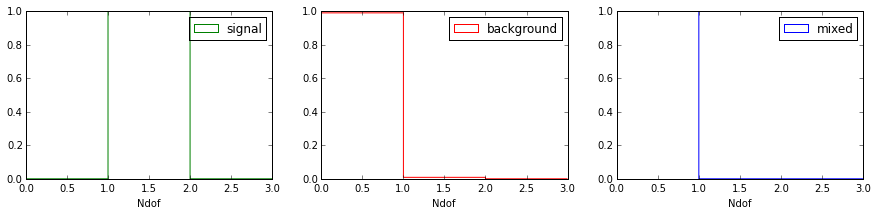

In [113]:
b = np.arange(0,4,1)
fig = plt.figure(1, figsize=(15,3))
fig.add_subplot(1,3,1)
n, bins, patches = plt.hist([o.ndof for o in orbits_s], bins=b, histtype='step', color='g', label='signal', normed=True)
plt.xlabel('Ndof')
plt.legend()
fig.add_subplot(1,3,2)
n, bins, patches = plt.hist([o.ndof for o in orbits_b], bins=b, histtype='step', color='r', label='background', normed=True)
plt.legend()
plt.xlabel('Ndof')
fig.add_subplot(1,3,3)
n, bins, patches = plt.hist([o.ndof for o in orbits_m], bins=b, histtype='step', color='b', label='mixed', normed=True)
plt.legend()
plt.xlabel('Ndof')
plt.savefig('triplets_ndof.pdf')

In [ ]:
a_true = [t.a for t in truth]
e_true = [t.e for t in truth]
i_true = [t.i for t in truth]
lan_true = [t.lan for t in truth]
#a_recon = [o.elements['a'] for o in orbits]
#e_recon = [o.elements['e'] for o in orbits]
#i_recon = [o.elements['i'] for o in orbits]
#lan_recon = [o.elements['lan'] for o in orbits]
a_recon = [t.a for t in found_truth]
e_recon = [t.e for t in found_truth]
i_recon = [t.i for t in found_truth]
lan_recon = [t.lan for t in found_truth]
print len(a_true), len(a_recon)


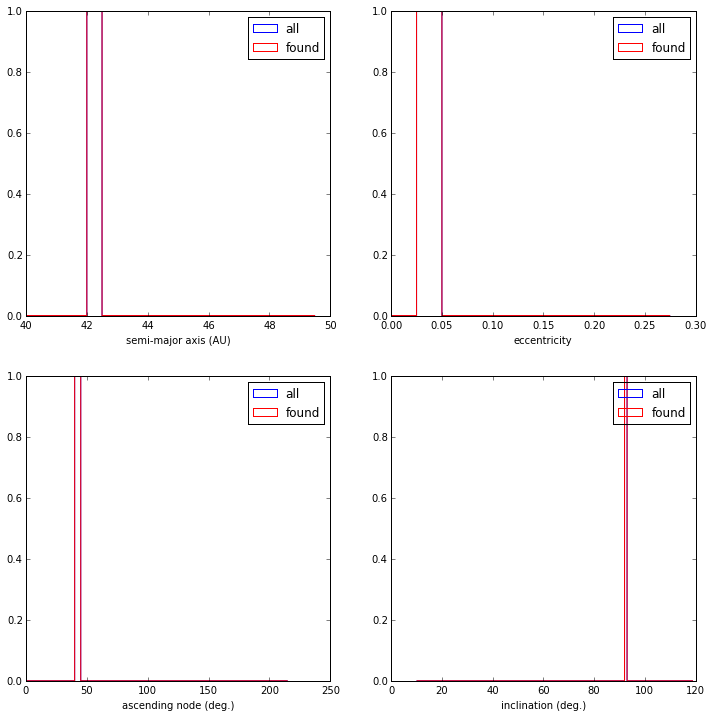

In [13]:
fig = plt.figure(1, figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
bins=np.arange(40,50,0.5)
n,bins,patches = ax1.hist(a_true, bins=bins, histtype='step', color='b', label='all')
n,bins,patches = ax1.hist(a_recon, bins=bins, histtype='step', color='r', label='found')
ax1.set_xlabel('semi-major axis (AU)')
plt.legend()

ax2 = fig.add_subplot(2,2,2)
bins=np.arange(0,0.3,0.025)
n,bins,patches = ax2.hist(e_true, bins=bins, histtype='step', color='b', label='all')
n,bins,patches = ax2.hist(e_recon, bins=bins, histtype='step', color='r', label='found')
ax2.set_xlabel('eccentricity')
plt.legend()

ax3 = fig.add_subplot(2,2,3)
bins=np.arange(0,220,5)
n,bins,patches = ax3.hist(lan_true, bins=bins, histtype='step', color='b', label='all')
n,bins,patches = ax3.hist(lan_recon, bins=bins, histtype='step', color='r', label='found')
ax3.set_xlabel('ascending node (deg.)')
plt.legend()

ax4 = fig.add_subplot(2,2,4)
bins=np.arange(10,120,1)
ntrue,bins,patches = ax4.hist(i_true, bins=bins, histtype='step', color='b', label='all')
nrecon,bins,patches = ax4.hist(i_recon, bins=bins, histtype='step', color='r', label='found')
ax4.set_xlabel('inclination (deg.)')
plt.legend()
plt.savefig('fake_recon.pdf')
plt.show()


So far this is good news... only 5 of 256 potentially reconstructable objects were not found. Next we'll look into why, and then start adding more realism to the linker, such as: smearing observations with the astrometric error, adding noise points, developing a real procedure to merge triplets, etc.

In [16]:
# This filters the pandas dataframe containing the truth table to select the objects that were not found.
df_not_found = fakes_truth[fakes_truth['fakeid'].isin(not_found_ids)]
#df_not_found

# They look fairly unremarkable.

In [17]:
# What were their "observations"?
df = fakes_det[fakes_det['fakeid'].isin(not_found_ids)]   # filter on fakeids of objects not found
obs_not_found= df[df['band']=='r'].sort(['fakeid','date_obs'],ascending=[True,True])  # select r-band, sort by fakeid and date.
#obs_not_found

# So what they have in common is that they all entered the field late in the season, when motion
# is at a turning point from retrograde to prograde. Maybe the geometrical extrapolations in the linker 
# break down then. (NB, ccd's 31, 38 are at the easternmost edge of the focal plane.)

So let's use the kinematic/geometrical information we've pulled out of the linker to see why we're missing these triplets. 

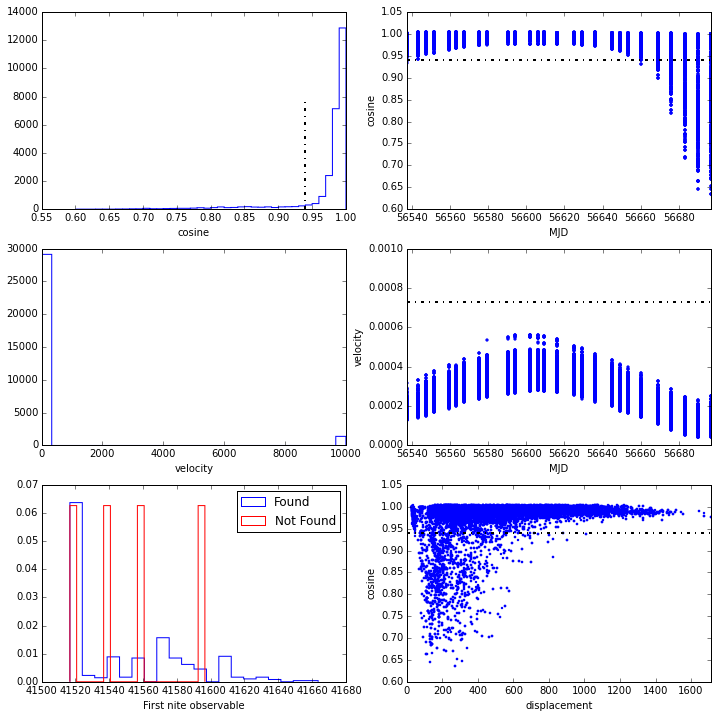

In [18]:
fig=plt.figure(2,figsize=(12,12))
ax = fig.add_subplot(3,2,1)
cos_list = [c['cos'] for c in linkstuff]
vel_list = [c['velocity'] for c in linkstuff]
norm_list = [c['norm'] for c in linkstuff]
displacement_list = 3600*180/np.pi*np.array([c['displacement'] for c in linkstuff])
dot_list =  [c['dot'] for c in linkstuff]
obj_dlon = [c['objdlon'] for c in linkstuff]
obj_dlat = [c['objdlat'] for c in linkstuff]
exp_dlon = [c['dlon'] for c in linkstuff]
exp_dlat = [c['dlat'] for c in linkstuff]
mjd_list = []
for c in linkstuff:
    objid = c['objid']
    this_obs = fakes_det.iloc[objid]
    mjd_list.append(this_obs.mjd_obs)
n,bins,patches = ax.hist(cos_list, bins=40, range=[0.6,1.0], histtype='step')
ax.plot([np.cos(20 * np.pi/180),np.cos(20 * np.pi/180)],[0,8000],lw=2,ls='-.',color='k')
ax.set_xlabel('cosine')

ax = fig.add_subplot(3,2,2)
ax.scatter(mjd_list, cos_list, s=5,color='b')
mjd_min=sorted(mjd_list)[0]
mjd_max=sorted(mjd_list)[-1]
ax.plot([mjd_min, mjd_max],[np.cos(20 * np.pi/180),np.cos(20 * np.pi/180)],lw=2,ls='-.',color='k')
ax.set_xlim([mjd_min, mjd_max])
ax.set_xlabel('MJD')
ax.set_ylabel('cosine')


ax = fig.add_subplot(3,2,3)
n, bins, patches = ax.hist(vel_list, bins=30, histtype='step')
v_cut = 150 * np.pi/648000
ax.plot([v_cut, v_cut],[0,1200],lw=2,ls='-.',color='k')
ax.set_xlabel('velocity')

ax = fig.add_subplot(3,2,4)
ax.scatter(mjd_list, vel_list, s=5,color='b')
mjd_min=sorted(mjd_list)[0]
mjd_max=sorted(mjd_list)[-1]
ax.plot([mjd_min, mjd_max],[v_cut, v_cut],lw=2,ls='-.',color='k')
ax.set_xlim([mjd_min, mjd_max])
ax.set_ylim([0,0.001])
ax.set_xlabel('MJD')
ax.set_ylabel('velocity')

ax = fig.add_subplot(3,2,5)
n, bins, patches = ax.hist(first_nite_found, bins=20, histtype='step', color='b',label='Found',normed=True )
n, bins, patches = ax.hist(first_nite_not_found, bins=20, histtype='step', color='r',label='Not Found',normed=True )
plt.legend()
ax.set_xlabel('First nite observable')

ax = fig.add_subplot(3,2,6)
d_min, d_max = sorted(displacement_list)[0], sorted(displacement_list)[-1]
ax.scatter(displacement_list, cos_list, s=2,color='b')
ax.set_xlim([d_min, d_max])
ax.plot([d_min,d_max],[np.cos(20 * np.pi/180),np.cos(20 * np.pi/180)],lw=2,ls='-.',color='k')
ax.set_xlabel('displacement')
ax.set_ylabel('cosine')

plt.savefig('linker_recon.pdf')
plt.show()

So the issue is that the cosine cut made in the linker does not match well to the late-season motion. The velocity cut looks OK. Need to deep-dive into the linker to see what's going on.

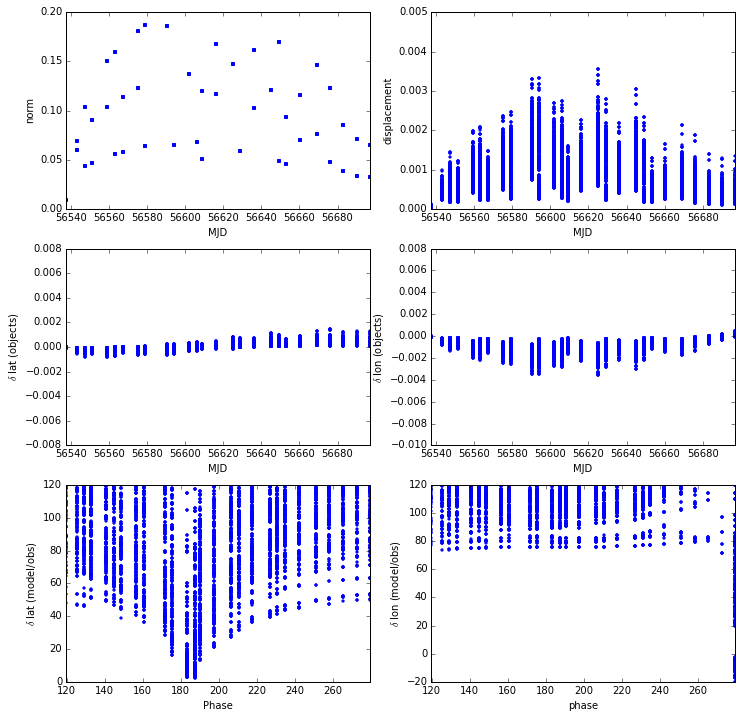

In [20]:
phase_list = []
sun = ephem.Sun()
for field in fields:
    if field.name==target:
        target_lon = Ecliptic(field.center).lon
for d in mjd_list:
    djd = d-15019.5
    sun.compute(djd)
    sun_lon, sun_lat = Ecliptic(Equatorial(sun.a_ra, sun.a_dec)).get()
    angle = (sun_lon-target_lon)*180/np.pi
    phase_list.append(angle)
phase_min=sorted(phase_list)[0]
phase_max=sorted(phase_list)[-1]
fig=plt.figure(3,figsize=(12,12))

ax = fig.add_subplot(3,2,1)
ax.scatter(mjd_list, norm_list, s=5,color='b')
mjd_min=sorted(mjd_list)[0]
mjd_max=sorted(mjd_list)[-1]
ax.set_xlim([mjd_min, mjd_max])
ax.set_ylim([0,0.2])
ax.set_xlabel('MJD')
ax.set_ylabel('norm')

ax = fig.add_subplot(3,2,2)
ax.scatter(mjd_list, displacement_list, s=5,color='b')
ax.set_xlim([mjd_min, mjd_max])
ax.set_ylim([0,0.2/40])
ax.set_xlabel('MJD')
ax.set_ylabel('displacement')

ax = fig.add_subplot(3,2,3)
ax.scatter(mjd_list, np.array(obj_dlat), s=5,color='b')
ax.set_xlim([mjd_min, mjd_max])
ax.set_xlabel('MJD')
ax.set_ylabel('$\delta$ lat (objects)')

ax = fig.add_subplot(3,2,4)
ax.scatter(mjd_list, np.array(obj_dlon), s=5,color='b')
ax.set_xlim([mjd_min, mjd_max])
ax.set_xlabel('MJD')
ax.set_ylabel('$\delta$ lon (objects)')

ax = fig.add_subplot(3,2,5)
ax.scatter(phase_list, np.array(exp_dlat)/np.array(obj_dlat), s=5,color='b')
ax.set_xlim([phase_min, phase_max])
ax.set_ylim([0,120])
ax.set_xlabel('Phase')
ax.set_ylabel('$\delta$ lat (model/obs)')

ax = fig.add_subplot(3,2,6)
ax.scatter(phase_list, np.array(exp_dlon)/np.array(obj_dlon), s=5,color='b')
ax.set_xlim([phase_min, phase_max])
ax.set_ylim([-20,120])
ax.set_xlabel('phase')
ax.set_ylabel('$\delta$ lon (model/obs)')

plt.show()


I think here is the rub. Given an initial point $p$ from a given visit, and a candidate point $q$ being evaluated from a subsequent visit, the linker does the following:

 * Compute the expected change in ecliptic coordinates for a hypothetical stationary object in the given field on the given date. This is done with the `anomalies` function in `KBO.py`. Call this vector $\vec{v}_{model}=(\delta\lambda_{model}$, $\delta\beta_{exp})$. Note that this is scaled to an object at 1 AU. The magnitude of this vector is called `norm` in the code. (Upper left plot.)
 * Compute the actual difference in ecliptic coords between $p$ and $q$. Call this vector $\vec{v}_{obs}=(\delta\lambda_{obs}$, $\delta\beta_{obs})$. The magnitude of this vector (i.e. the actual separation of the two points on the sky) is called `displacement` in the code. (Upper right plot.) Notice the difference in vertical scales of the two upper plots. The objects being linked here are at $\sim$40 AU, so the displacement is correspondingly smaller. 0.05/40 = 0.0125.
 * I am not sure why the `norm` and `displacement` plots are as discontinuous as they appear. `norm`, in particular, has nothing to do with individual objects; it depends only on visits. I guess the issue is the variable time between visits.
 * Compute the dot product:
 $$
       \vec{v}_{model}\cdot\vec{v}_{obs} = \mathrm{(norm)}\mathrm{(displacement)}\cos\theta
 $$
 * Hence $\cos\theta =$ `dot`/(`norm`*`displacement`). The linker somewhat arbitrarily requires this to be greater than $\cos 20^{\circ}$.
 * The middle two plots show the difference in lat and long between adjacent visits for object points, i.e. the components of $\vec{v}_{obs}$.
 * The bottom two plots show the *ratios* $\delta\beta_{model}/\delta\beta_{exp}$ and $\delta\lambda_{model}/\delta\lambda_{exp}$. All is OK if these are flat; normalization differences will scale out. But in the lower right plot we see a problem in the late-season behavior of this ratio for the ecliptic longitude motion. 
 * I think the issue is that the object is at a turning point here, so motion in ecliptic longitude is very small. We are trying to look for an alignment between two vectors with different lengths but nominally similar directions. But when one component vanishes or nearly does, it injects noise into the calculation and causes the point to fail the cosine cut.

Linker code, for reference:

            for obj in current_objects:
                objlon, objlat = Ecliptic(Equatorial(obj.ra, obj.dec)).get()
                dlon, dlat = nextvisit.dlon - thisvisit.dlon, nextvisit.dlat - thisvisit.dlat
                displacement = ephem.separation((objlon, objlat), (lon, lat))
                norm = np.sqrt(np.cos(centerlat)**2*dlon**2 + dlat**2)
                dot = np.cos(centerlat)**2*(objlon - lon)*dlon + (objlat - lat)*dlat
                if obj.date != point.date:
                     velocity = displacement/(obj.date - point.date)
                else: 
                     break
                cosine = dot/(norm*displacement)
                linkstuff.append(
                    dict([('cos',cosine),('objid', obj.objid),('velocity',velocity),
                         ('dlon',dlon), ('dlat',dlat), ('displacement',displacement),
                         ('norm',norm),('dot',dot),('objdlon',objlon-lon),('objdlat',objlat-lat)]
                        ))
                if cosine > np.cos(20 * np.pi/180) and velocity < 150 * np.pi/(180*3600): # arcsec/day
                    next_obj.append(obj)